# Construct a figure showing sensitivity analysis results:

example notebook to create a figure to show sensitivity analysis results by Beo

In [2]:
import pandas as pd
import matplotlib.pyplot as pl

In [3]:
# name of the file containing the data in .csv format
data_file = 'data/example_data.csv'

Define the columns that contain the input parameters and model results:

In [4]:
# name of the index column:
index_column = 'index'

# index row for the base case model
base_case_model = 0

# list the parameters that you want to include
sensitivity_params = ['q', 'duration']

# list the first and last index row for each parameter
param_rows = [[1, 3], [4, 6]]

# show the percentage change or the ratio of each parameter comapred to the base case:
x_axis_scale = 'fraction'

# what to plot on the y axis
result_param = 'width'

Some parameters that control how the figure looks:

In [18]:
# markers for the different parameters
markers = ['o', 'o']
base_case_marker = '*'
marker_size = 50
base_case_marker_size = 150

# labels for the legend
labels = [r'Flux (m$^2$yr$^{-1}$)', 'Duration (yr)']

# label on x and y-axis
xlabel = 'Parameter change (fraction)'
ylabel = 'Width of the AHe partial resetting zone (m)'

# limits of the x and y-axis
xlim = [0, 2.0]
ylim = [0, 50]

# colors for the different parameters
# use standard colors like this:
#colors = ['blue', 'orange']
# or check here for nicer RGB color schemes: http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
colors = [[102/255., 194/255., 165/255.], [252/255., 141/255., 98/255.], [141/255., 160/255., 203/255.]]

legend_location = 'upper left'
legend_font_size = 'small'

# figure size (in inches):
figsize = (6, 4)

Read the data file:

In [19]:
# read the datafile using pandas:
df = pd.read_csv(data_file)
df = df.set_index(index_column)

make the figure:

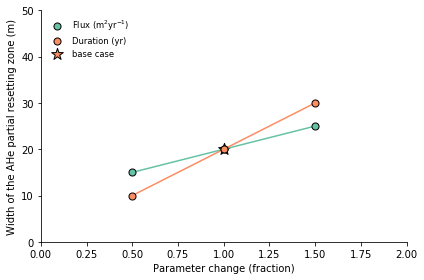

In [21]:
fig, panel = pl.subplots(1, 1, figsize=figsize)

for param, param_row, color, marker, label in zip(sensitivity_params, param_rows, colors, markers, labels):

    base_value_x = df.loc[base_case_model, param]
    base_value_y = df.loc[base_case_model, result_param]

    param_values = df.loc[param_row[0]:param_row[1], param]

    if x_axis_scale is 'fraction':
        x_values = param_values / base_value_x

    y_values = df.loc[param_row[0]:param_row[1], result_param]

    panel.plot(x_values, y_values, color=color, label='', zorder=100)
    panel.scatter(x_values, y_values, color=color, edgecolor='black', marker=marker, s=marker_size, label=label, zorder=101)

# show the base case value:
panel.scatter([1.0], [base_value_y],
              color=color, edgecolor='black', marker=base_case_marker,
              s=base_case_marker_size, label='base case', zorder=100)

# add a legend:
panel.legend(loc=legend_location, ncol=1, frameon=False, fontsize=legend_font_size)

# add labels and rescale the axis
panel.set_xlabel(xlabel)
panel.set_ylabel(ylabel)
panel.set_xlim(xlim)
panel.set_ylim(ylim)

# make the figure look nicer:
panel.grid(False)
panel.spines['top'].set_visible(False)
panel.spines['right'].set_visible(False)
panel.get_xaxis().tick_bottom()
panel.get_yaxis().tick_left()
fig.tight_layout()

and save the figure:

In [8]:
# svae the figure as pdf and png file
fn = data_file[:-4] + '_sensitivity_fig.pdf'
print('done, saving figure as %s' % fn)
fig.savefig(fn)

done, saving figure as data/example_data_sensitivity_fig.pdf
